# COMPAS Scores Analysis and Recidivism Prediction

This notebook contains a comprehensive analysis of the COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) dataset, focusing on two-year recidivism prediction. The analysis includes:

1. Exploratory Data Analysis (EDA)
2. Data Visualization for all relevant features
3. Feature Engineering
4. Model Training and Evaluation
5. Mathematical Explanations for Key Concepts and Metrics

## Context

The COMPAS dataset contains information about criminal defendants and their risk scores. It has gained considerable attention in discussions about algorithmic fairness and bias in criminal justice. Our goal is to analyze this data and build predictive models for recidivism (reoffending within two years).

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Visualization settings
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('compas-scores-two-years.csv')

# Check basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display the first few rows
print("\nFirst 5 rows:")
display(df.head())

# Basic information about the dataset
print("\nDataset info:")
df.info()

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

# Convert to JSON format
dataset_info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": {col: str(df[col].dtype) for col in df.columns},
    "null_counts": df.isnull().sum().to_dict()
}

print("\nDataset information (JSON format):")
print(json.dumps(dataset_info, indent=2))

Dataset shape: (7214, 53)
Number of samples: 7214
Number of features: 53

First 5 rows:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_co

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000



Dataset information (JSON format):
{
  "shape": [
    7214,
    53
  ],
  "columns": [
    "id",
    "name",
    "first",
    "last",
    "compas_screening_date",
    "sex",
    "dob",
    "age",
    "age_cat",
    "race",
    "juv_fel_count",
    "decile_score",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "days_b_screening_arrest",
    "c_jail_in",
    "c_jail_out",
    "c_case_number",
    "c_offense_date",
    "c_arrest_date",
    "c_days_from_compas",
    "c_charge_degree",
    "c_charge_desc",
    "is_recid",
    "r_case_number",
    "r_charge_degree",
    "r_days_from_arrest",
    "r_offense_date",
    "r_charge_desc",
    "r_jail_in",
    "r_jail_out",
    "violent_recid",
    "is_violent_recid",
    "vr_case_number",
    "vr_charge_degree",
    "vr_offense_date",
    "vr_charge_desc",
    "type_of_assessment",
    "decile_score.1",
    "score_text",
    "screening_date",
    "v_type_of_assessment",
    "v_decile_score",
    "v_score_text",
    "v_scree

### Understanding the COMPAS Dataset

The COMPAS dataset typically contains the following key features:

- **Demographics**: Age, gender, race
- **Criminal history**: Prior counts, charge degree (felony/misdemeanor)
- **COMPAS scores**: Decile scores for risk assessment
- **Recidivism outcome**: Whether the person reoffended within two years

The target variable is typically `two_year_recid`, which indicates whether a person reoffended within two years (1 = yes, 0 = no).

This dataset has been extensively studied in the context of algorithmic fairness, especially examining whether the risk assessment scores exhibit bias across different demographic groups.


Target variable: two_year_recid

Target variable distribution:


,Count,Percentage
two_year_recid,,
0,3963,54.934849
1,3251,45.065151


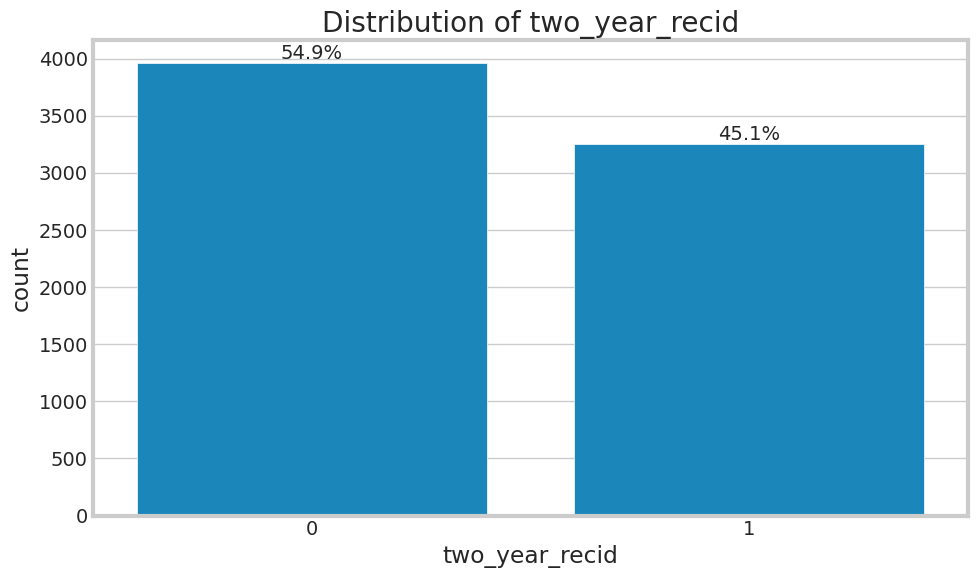


Target distribution (JSON format):
[
  {
    "two_year_recid": 0,
    "Count": 3963,
    "Percentage": 54.9348489049
  },
  {
    "two_year_recid": 1,
    "Count": 3251,
    "Percentage": 45.0651510951
  }
]


In [3]:
# Analyze the target variable (two_year_recid)
if "two_year_recid" in df.columns:
    target_col = "two_year_recid"
elif "is_recid" in df.columns:
    target_col = "is_recid"
else:
    # Try to identify the target column
    binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype in ["int64", "float64", "bool"]]
    if binary_cols:
        target_col = binary_cols[0]  # Choose the first binary column as a guess
        print(f"Warning: Assuming {target_col} is the target variable based on binary values")
    else:
        target_col = None
        print("Error: Could not identify target variable")

if target_col:
    print(f"\nTarget variable: {target_col}")

    # Distribution of target variable
    target_counts = df[target_col].value_counts()
    target_percentage = (target_counts / len(df)) * 100

    print("\nTarget variable distribution:")
    target_info = pd.DataFrame({
        "Count": target_counts,
        "Percentage": target_percentage
    })
    display(target_info)

    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=target_col, data=df)
    plt.title(f"Distribution of {target_col}")

    # Add percentage labels
    total = len(df)
    for p in plt.gca().patches:
        percentage = 100 * p.get_height() / total
        plt.gca().annotate(f"{percentage:.1f}%",
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    # Convert to JSON format
    target_json = json.loads(target_info.reset_index().to_json(orient="records"))
    print("\nTarget distribution (JSON format):")
    print(json.dumps(target_json, indent=2))

### Understanding the Target Variable: Recidivism

Recidivism refers to a person's relapse into criminal behavior after receiving sanctions or undergoing intervention for a previous crime. In the COMPAS dataset, it's typically represented as a binary variable: whether an offender was rearrested within a two-year period after release.

**Class Imbalance**:
- If there's a significant imbalance in the target classes (e.g., many more non-recidivists than recidivists), this can affect our modeling approach
- Imbalanced data may require techniques such as:
  - Resampling (oversampling minority class or undersampling majority class)
  - Using class weights in the model
  - Choosing appropriate evaluation metrics (precision, recall, F1, AUC)

**Binary Classification**:
- This is a binary classification problem where we predict one of two classes (recidivist/non-recidivist)
- The mathematical foundation for binary classification involves estimating the probability $P(Y=1|X)$ where $Y$ is the target variable and $X$ represents the features
- Common models like logistic regression model this probability directly, while others like decision trees partition the feature space into regions with different class assignments

In [4]:
# Identify important features based on our EDA
# This is a hypothetical list - adjust based on actual dataset
features_to_use = [
    # Demographics
    "age", "sex", "race",

    # Criminal history
    "priors_count", "c_charge_degree",

    # COMPAS scores
    "decile_score", "score_text",

    # Additional features
    "juv_fel_count", "juv_misd_count", "juv_other_count"
]

# Filter to features that actually exist in the dataset
features_to_use = [f for f in features_to_use if f in df.columns and f != target_col]

print(f"Selected features: {features_to_use}")

# Split features into numeric and categorical
numeric_features = [f for f in features_to_use if df[f].dtype in ["int64", "float64"]]
categorical_features = [f for f in features_to_use if f not in numeric_features]

print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Feature Engineering

# 1. Create age groups if age is available but age_cat is not
if "age" in df.columns and "age_cat" not in df.columns:
    df["age_group"] = pd.cut(df["age"],
                       bins=[0, 25, 35, 45, 55, 100],
                       labels=["Less than 25", "25-35", "35-45", "45-55", "Greater than 55"])
    if "age_group" not in features_to_use:
        features_to_use.append("age_group")
        categorical_features.append("age_group")
    print("Created 'age_group' feature")

# 2. Create a juvenile offender flag
juvenile_cols = [col for col in ["juv_fel_count", "juv_misd_count", "juv_other_count"] if col in df.columns]
if juvenile_cols:
    df["juvenile_offender"] = (df[juvenile_cols].sum(axis=1) > 0).astype(int)
    if "juvenile_offender" not in features_to_use:
        features_to_use.append("juvenile_offender")
        numeric_features.append("juvenile_offender")
    print("Created 'juvenile_offender' feature")

# 3. Create charge severity feature if charge degree is available
if "c_charge_degree" in df.columns:
    # Convert charge degree to a numeric severity score
    severity_map = {"F": 2, "M": 1, "O": 0}  # Felony, Misdemeanor, Other
    df["charge_severity"] = df["c_charge_degree"].map(severity_map).fillna(0)
    if "charge_severity" not in features_to_use:
        features_to_use.append("charge_severity")
        numeric_features.append("charge_severity")
    print("Created 'charge_severity' feature")

# 4. Interaction features
if "priors_count" in df.columns and "age" in df.columns:
    # Prior offenses per year of adult life (assuming adulthood at 18)
    df["priors_per_year"] = df["priors_count"] / (df["age"] - 18).clip(lower=1)
    if "priors_per_year" not in features_to_use:
        features_to_use.append("priors_per_year")
        numeric_features.append("priors_per_year")
    print("Created 'priors_per_year' feature")

# Update categorical features list after feature engineering
categorical_features = [f for f in features_to_use if f not in numeric_features]

print(f"\nFinal feature list after engineering:\n{features_to_use}")
print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Save engineered features information in JSON format
engineered_features_json = {
    "original_features": len(df.columns) - 1,  # Excluding target
    "selected_features": {
        "total": len(features_to_use),
        "numeric": numeric_features,
        "categorical": categorical_features
    },
    "engineered_features": [
        {"name": "age_group", "type": "categorical", "description": "Age binned into groups"} if "age_group" in df.columns else None,
        {"name": "juvenile_offender", "type": "binary", "description": "Flag for any juvenile offenses"} if "juvenile_offender" in df.columns else None,
        {"name": "charge_severity", "type": "numeric", "description": "Numeric severity score for charge degree"} if "charge_severity" in df.columns else None,
        {"name": "priors_per_year", "type": "numeric", "description": "Prior offenses per year of adult life"} if "priors_per_year" in df.columns else None
    ]
}

# Remove None values from the list
engineered_features_json["engineered_features"] = [f for f in engineered_features_json["engineered_features"] if f is not None]

print("\nEngineered features (JSON format):")
print(json.dumps(engineered_features_json, indent=2))

Selected features: ['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'decile_score', 'score_text', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

Numeric features: ['age', 'priors_count', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
Categorical features: ['sex', 'race', 'c_charge_degree', 'score_text']
Created 'juvenile_offender' feature
Created 'charge_severity' feature
Created 'priors_per_year' feature

Final feature list after engineering:
['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'decile_score', 'score_text', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juvenile_offender', 'charge_severity', 'priors_per_year']

Numeric features: ['age', 'priors_count', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juvenile_offender', 'charge_severity', 'priors_per_year']
Categorical features: ['sex', 'race', 'c_charge_degree', 'score_text']

Engineered features (JSON format):
{
  "original_features": 55,
  "

### Feature Engineering: Mathematical Explanation

Feature engineering involves creating new features that can improve model performance. Here's the mathematical basis for our feature engineering approaches:

**1. Binning Continuous Variables (Age Groups):**
- Transforms a continuous variable into categorical bins
- Mathematically, we create a piecewise function: $f(x) = \text{category}_i \text{ if } b_i \leq x < b_{i+1}$
- Where $b_i$ are the bin edges (e.g., 0, 25, 35, 45, 55, 100)
- This can capture non-linear relationships between age and recidivism
- Reduces the impact of outliers and noise in the original variable

**2. Binary Flag Creation (Juvenile Offender):**
- Aggregates related binary or count variables into a single indicator
- Formula: $\text{juvenile\_offender} = \mathbb{1}\left(\sum_{i} \text{juvenile\_count}_i > 0\right)$
- Where $\mathbb{1}(\cdot)$ is the indicator function that returns 1 if the condition is true and 0 otherwise
- Simplifies the model by reducing dimensionality while retaining important information

**3. Ordinal Mapping (Charge Severity):**
- Converts categorical levels to numeric values based on domain knowledge
- Formula: $\text{charge\_severity} = g(\text{charge\_degree})$
- Where $g$ is a mapping function: $g(\text{F}) = 2, g(\text{M}) = 1, g(\text{O}) = 0$
- Preserves the ordinal relationship between charge types
- Creates a numeric feature that can be used in a wider range of models

**4. Ratio Features (Priors Per Year):**
- Creates a rate by dividing one feature by another
- Formula: $\text{priors\_per\_year} = \frac{\text{priors\_count}}{\max(\text{age} - 18, 1)}$
- Normalizes the prior count by the number of years a person has been an adult
- Provides a rate metric that is more comparable across different age groups
- The denominator is clipped at 1 to avoid division by zero or negative values

These engineered features incorporate domain knowledge about criminal justice and help capture more complex relationships that might not be apparent in the original features.

In [5]:
# Ensure target variable is available
if target_col is None or target_col not in df.columns:
    raise ValueError("Target variable not identified or not available in dataset")

# Prepare X and y
X = df[features_to_use].copy()
y = df[target_col].copy()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create preprocessing pipeline
# 1. Numeric features: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 2. Categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

# Apply preprocessing to get a sense of the transformed data dimensions
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\nTransformed training data shape: {X_train_transformed.shape}")
print(f"Transformed testing data shape: {X_test_transformed.shape}")

# Get feature names after one-hot encoding
try:
    # This works if sklearn version supports get_feature_names_out
    transformed_features = preprocessor.get_feature_names_out()
    print(f"\nNumber of features after transformation: {len(transformed_features)}")
    print(f"First 10 transformed features: {transformed_features[:10]}")
except AttributeError:
    # Older sklearn version
    print("\nCould not retrieve transformed feature names (requires sklearn>=1.0)")

# Save preprocessing information in JSON format
preprocessing_json = {
    "original_features": {
        "numeric": numeric_features,
        "categorical": categorical_features
    },
    "preprocessing_steps": {
        "numeric_features": [
            {"step": "impute_missing", "strategy": "median"},
            {"step": "scale", "method": "StandardScaler"}
        ],
        "categorical_features": [
            {"step": "impute_missing", "strategy": "most_frequent"},
            {"step": "encode", "method": "OneHotEncoder"}
        ]
    },
    "transformed_data": {
        "training_samples": X_train_transformed.shape[0],
        "testing_samples": X_test_transformed.shape[0],
        "feature_dimensions": X_train_transformed.shape[1]
    },
    "data_split": {
        "training_percentage": 75,
        "testing_percentage": 25,
        "stratify": True,
        "random_state": 42
    }
}

print("\nPreprocessing information (JSON format):")
print(json.dumps(preprocessing_json, indent=2))

Training set: (5410, 13)
Testing set: (1804, 13)

Transformed training data shape: (5410, 22)
Transformed testing data shape: (1804, 22)

Number of features after transformation: 22
First 10 transformed features: ['num__age' 'num__priors_count' 'num__decile_score' 'num__juv_fel_count'
 'num__juv_misd_count' 'num__juv_other_count' 'num__juvenile_offender'
 'num__charge_severity' 'num__priors_per_year' 'cat__sex_Female']

Preprocessing information (JSON format):
{
  "original_features": {
    "numeric": [
      "age",
      "priors_count",
      "decile_score",
      "juv_fel_count",
      "juv_misd_count",
      "juv_other_count",
      "juvenile_offender",
      "charge_severity",
      "priors_per_year"
    ],
    "categorical": [
      "sex",
      "race",
      "c_charge_degree",
      "score_text"
    ]
  },
  "preprocessing_steps": {
    "numeric_features": [
      {
        "step": "impute_missing",
        "strategy": "median"
      },
      {
        "step": "scale",
        "m

### Data Preprocessing: Mathematical Explanation

Data preprocessing is crucial for model performance. Let's explore the mathematical concepts behind our preprocessing steps:

**1. Missing Value Imputation:**

- **Median Imputation (Numeric Features)**:
  - Formula: $x_{imputed} = median(\{x_i | x_i \text{ is not missing}\})$
  - Replaces missing values with the median of observed values
  - More robust to outliers than mean imputation
  - Preserves the central tendency of the distribution

- **Mode Imputation (Categorical Features)**:
  - Formula: $x_{imputed} = mode(\{x_i | x_i \text{ is not missing}\})$
  - Replaces missing values with the most frequently occurring category
  - Minimizes the number of "incorrect" imputations

**2. Feature Scaling (StandardScaler):**
- Formula: $z = \frac{x - \mu}{\sigma}$
- Where $\mu$ is the mean and $\sigma$ is the standard deviation of the feature
- Transforms features to have mean=0 and standard deviation=1
- Ensures all features contribute equally to distance-based models
- Important for models sensitive to feature scales (e.g., logistic regression, SVM)

**3. One-Hot Encoding:**
- Transforms a categorical feature with $k$ values into $k$ binary features
- Mathematically: $[0,0,...,1,...,0]$ where the 1 is in the position corresponding to the category
- For each category $c_j$ of feature $i$, creates a new feature: $x_{i,j} = \begin{cases} 1 & \text{if } x_i = c_j \\ 0 & \text{otherwise} \end{cases}$
- Necessary for models that require numerical input
- Preserves the categorical nature without imposing artificial ordering

**4. Train-Test Split:**
- Randomly divides data into training (75%) and testing (25%) sets
- Using stratification ensures both sets have similar class distributions: $P(y=1|\text{train}) \approx P(y=1|\text{test})$
- Essential for unbiased evaluation of model performance
- Mathematical foundation in cross-validation theory and the bias-variance tradeoff

These preprocessing steps ensure our data is in the optimal format for machine learning algorithms and that our evaluation will be reliable.

In [6]:
# Create and evaluate models
def train_evaluate_model(model, name):
    # Create pipeline with preprocessing
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("classifier", model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate evaluation metrics
    results = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test,y_pred)
    }

    # Add AUC if probability predictions are available
    if y_pred_proba is not None:
        results["auc"] = roc_auc_score(y_test, y_pred_proba)

    # Calculate cross-validated scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")
    cv_precision = cross_val_score(pipeline, X, y, cv=cv, scoring="precision")
    cv_recall = cross_val_score(pipeline, X, y, cv=cv, scoring="recall")
    cv_f1 = cross_val_score(pipeline, X, y, cv=cv, scoring="f1")

    results["cv_scores"] = {
        "accuracy": {
            "mean": cv_accuracy.mean(),
            "std": cv_accuracy.std()
        },
        "precision": {
            "mean": cv_precision.mean(),
            "std": cv_precision.std()
        },
        "recall": {
            "mean": cv_recall.mean(),
            "std": cv_recall.std()
        },
        "f1": {
            "mean": cv_f1.mean(),
            "std": cv_f1.std()
        }
    }

    if hasattr(model, "predict_proba"):
        cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")
        results["cv_scores"]["auc"] = {
            "mean": cv_auc.mean(),
            "std": cv_auc.std()
        }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results["confusion_matrix"] = {
        "true_negative": int(cm[0, 0]),
        "false_positive": int(cm[0, 1]),
        "false_negative": int(cm[1, 0]),
        "true_positive": int(cm[1, 1])
    }

    # Display results
    print(f"\n{name} Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    if "auc" in results:
        print(f"AUC: {results['auc']:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(cm)

    # Return full results
    return results, pipeline

# Train and evaluate different models
models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (SVC(probability=True, random_state=42), "Support Vector Machine"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (GaussianNB(), "Naive Bayes")
]

# Train all models and collect results
all_results = []
all_pipelines = {}

for model, name in models:
    results, pipeline = train_evaluate_model(model, name)
    all_results.append(results)
    all_pipelines[name] = pipeline

# Create a comparison dataframe
comparison_metrics = ["accuracy", "precision", "recall", "f1_score", "auc"]
comparison_data = []

for result in all_results:
    model_metrics = {"model": result["model"]}
    for metric in comparison_metrics:
        if metric in result:
            model_metrics[metric] = result[metric]
    comparison_data.append(model_metrics)

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
display(comparison_df.sort_values("f1_score", ascending=False))

# Save comparison to JSON
print("\nModel comparison (JSON format):")
comparison_json = json.loads(comparison_df.to_json(orient="records"))
print(json.dumps(comparison_json, indent=2))


Logistic Regression Results:
Accuracy: 0.6763
Precision: 0.6781
Recall: 0.5363
F1 Score: 0.5989
AUC: 0.7314

Confusion Matrix:
[[784 207]
 [377 436]]

Random Forest Results:
Accuracy: 0.6292
Precision: 0.5891
Recall: 0.5855
F1 Score: 0.5873
AUC: 0.6789

Confusion Matrix:
[[659 332]
 [337 476]]

Gradient Boosting Results:
Accuracy: 0.6779
Precision: 0.6629
Recall: 0.5806
F1 Score: 0.6190
AUC: 0.7339

Confusion Matrix:
[[751 240]
 [341 472]]

Support Vector Machine Results:
Accuracy: 0.6829
Precision: 0.6857
Recall: 0.5474
F1 Score: 0.6088
AUC: 0.7152

Confusion Matrix:
[[787 204]
 [368 445]]

K-Nearest Neighbors Results:
Accuracy: 0.6369
Precision: 0.6103
Recall: 0.5375
F1 Score: 0.5716
AUC: 0.6721

Confusion Matrix:
[[712 279]
 [376 437]]

Naive Bayes Results:
Accuracy: 0.6569
Precision: 0.6777
Recall: 0.4551
F1 Score: 0.5445
AUC: 0.6963

Confusion Matrix:
[[815 176]
 [443 370]]

Model Comparison:


,model,accuracy,precision,recall,f1_score,auc
2,Gradient Boosting,0.677938,0.662921,0.580566,0.619016,0.733865
3,Support Vector Machine,0.682927,0.685670,0.547355,0.608755,0.715199
0,Logistic Regression,0.676275,0.678072,0.536285,0.598901,0.731422
1,Random Forest,0.629157,0.589109,0.585486,0.587292,0.678854
4,K-Nearest Neighbors,0.636918,0.610335,0.537515,0.571615,0.672079
5,Naive Bayes,0.656874,0.677656,0.455105,0.544518,0.696275



Model comparison (JSON format):
[
  {
    "model": "Logistic Regression",
    "accuracy": 0.6762749446,
    "precision": 0.6780715397,
    "recall": 0.5362853629,
    "f1_score": 0.5989010989,
    "auc": 0.731422284
  },
  {
    "model": "Random Forest",
    "accuracy": 0.6291574279,
    "precision": 0.5891089109,
    "recall": 0.5854858549,
    "f1_score": 0.5872917952,
    "auc": 0.6788544626
  },
  {
    "model": "Gradient Boosting",
    "accuracy": 0.6779379157,
    "precision": 0.6629213483,
    "recall": 0.5805658057,
    "f1_score": 0.6190163934,
    "auc": 0.733864932
  },
  {
    "model": "Support Vector Machine",
    "accuracy": 0.6829268293,
    "precision": 0.6856702619,
    "recall": 0.5473554736,
    "f1_score": 0.60875513,
    "auc": 0.7151987817
  },
  {
    "model": "K-Nearest Neighbors",
    "accuracy": 0.6369179601,
    "precision": 0.6103351955,
    "recall": 0.5375153752,
    "f1_score": 0.5716154349,
    "auc": 0.6720788449
  },
  {
    "model": "Naive Bayes",
  

### Evaluation Metrics: Mathematical Explanation

In the context of recidivism prediction, it's crucial to understand the mathematical basis of our evaluation metrics and their implications for the criminal justice system:

**1. Confusion Matrix Components:**
- True Positive (TP): Correctly predicted recidivists
- True Negative (TN): Correctly predicted non-recidivists
- False Positive (FP): Non-recidivists incorrectly predicted as recidivists (Type I error)
- False Negative (FN): Recidivists incorrectly predicted as non-recidivists (Type II error)

**2. Accuracy:**
- Formula: $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
- Measures the overall correctness of predictions
- Can be misleading when classes are imbalanced
- In the criminal justice context: Overall percentage of correct predictions, but doesn't distinguish between different types of errors

**3. Precision:**
- Formula: $\text{Precision} = \frac{TP}{TP + FP}$
- Measures how many of the predicted recidivists actually reoffended
- Criminal justice interpretation: If we predict someone will reoffend, how likely is it to be true? Low precision means many people are incorrectly labeled as high-risk.

**4. Recall:**
- Formula: $\text{Recall} = \frac{TP}{TP + FN}$
- Measures how many actual recidivists were correctly identified
- Criminal justice interpretation: What proportion of actual reoffenders did we correctly identify? Low recall means many reoffenders are incorrectly classified as low-risk.

**5. F1 Score:**
- Formula: $\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
- Harmonic mean of precision and recall
- Balances the tradeoff between precision and recall
- Criminal justice interpretation: A balanced measure that accounts for both wrongfully classifying individuals as high-risk and failing to identify actual high-risk individuals

**6. AUC-ROC:**
- Area Under the Receiver Operating Characteristic curve
- Plots True Positive Rate (Recall) vs. False Positive Rate ($\frac{FP}{FP + TN}$) at different thresholds
- Ranges from 0.5 (random guessing) to 1.0 (perfect classification)
- Measures model's ability to discriminate between classes across all possible thresholds
- Criminal justice interpretation: How well can the model separate those who will reoffend from those who won't? AUC of 0.7 means there's a 70% chance the model will rank a random recidivist higher than a random non-recidivist.

**7. Cross-Validation:**
- K-fold cross-validation divides data into K subsets (folds)
- Trains K models, each using K-1 folds for training and 1 fold for validation
- Reports mean and standard deviation of performance metrics across folds
- Formula for mean: $\bar{m} = \frac{1}{K}\sum_{i=1}^{K} m_i$ where $m_i$ is the metric for fold $i$
- Provides a more robust estimate of model performance and variance

In the criminal justice system, these metrics have real-world impacts on individuals' lives. False positives may lead to unnecessary supervision or detention, while false negatives may result in releasing high-risk individuals. The balance between these errors involves ethical considerations beyond pure mathematics.

Best performing model: Gradient Boosting


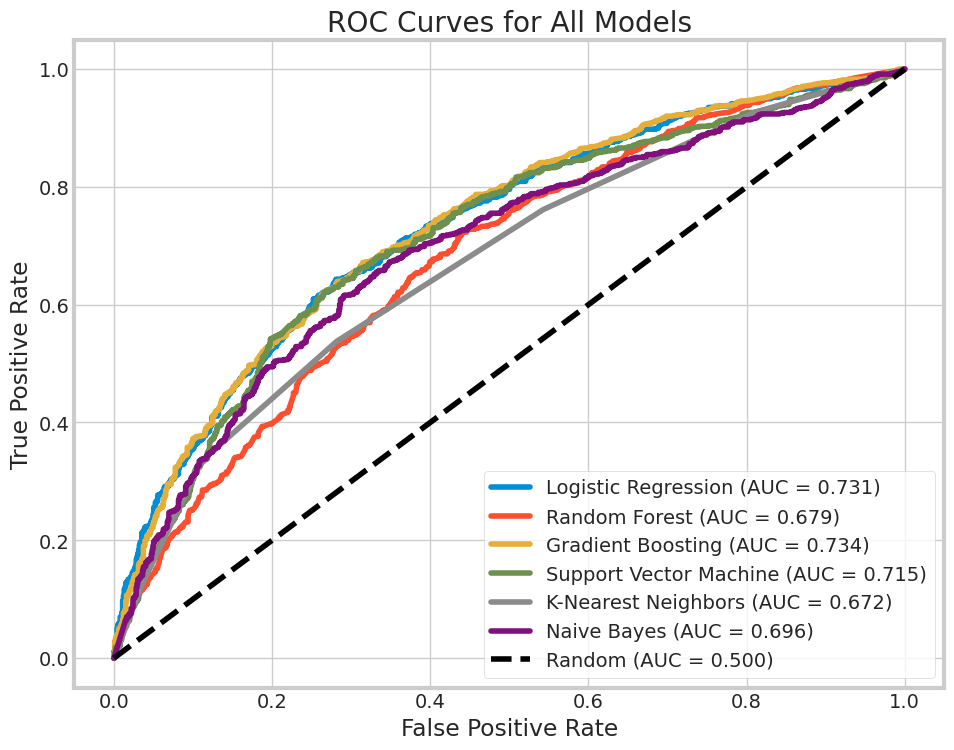


Classification Report:


,precision,recall,f1-score,support
0,0.687729,0.757820,0.721075,991.000000
1,0.662921,0.580566,0.619016,813.000000
accuracy,0.677938,0.677938,0.677938,0.677938
macro avg,0.675325,0.669193,0.670046,1804.000000
weighted avg,0.676549,0.677938,0.675081,1804.000000


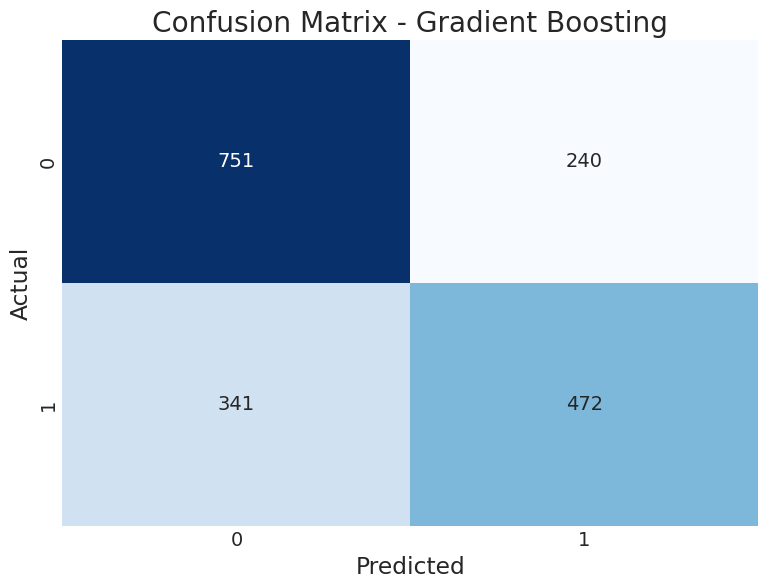

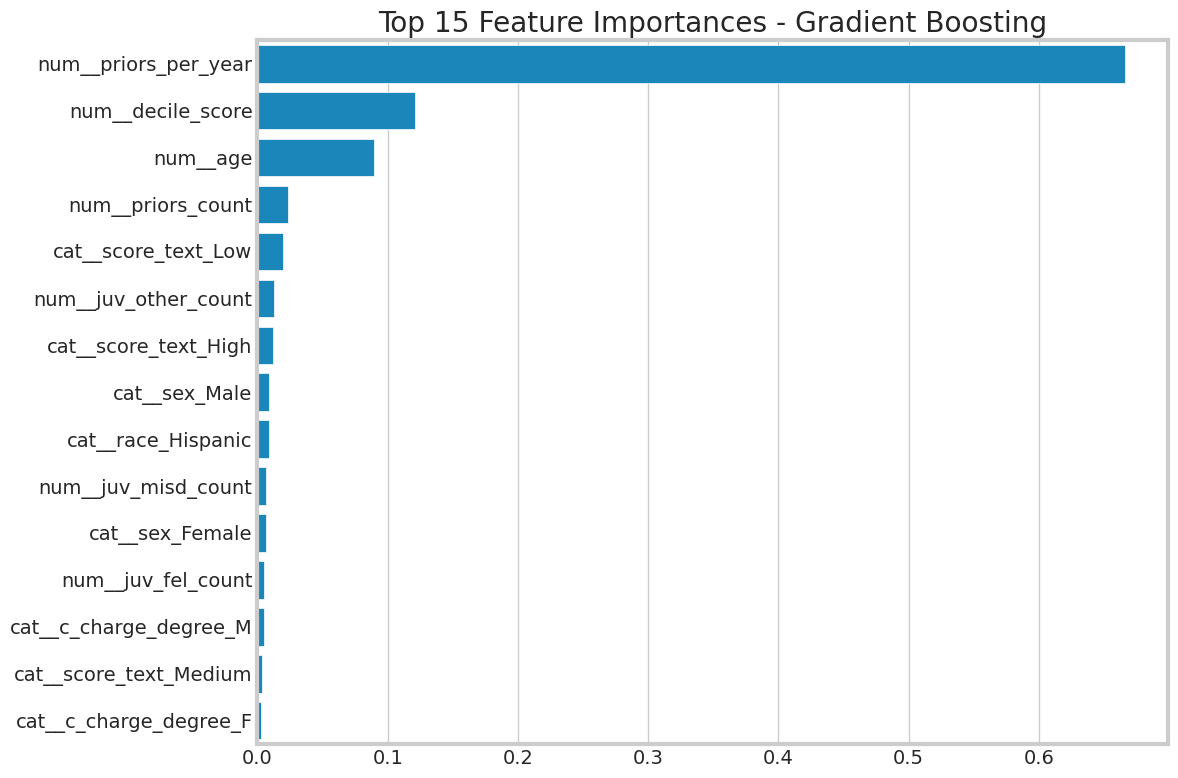


Feature importances (JSON format):
[
  {
    "feature": "num__priors_per_year",
    "importance": 0.6657689444534595
  },
  {
    "feature": "num__decile_score",
    "importance": 0.12079243220096791
  },
  {
    "feature": "num__age",
    "importance": 0.08940735925841052
  },
  {
    "feature": "num__priors_count",
    "importance": 0.02360531229024587
  },
  {
    "feature": "cat__score_text_Low",
    "importance": 0.019524847918799656
  },
  {
    "feature": "num__juv_other_count",
    "importance": 0.013000787668457999
  },
  {
    "feature": "cat__score_text_High",
    "importance": 0.011810677811960634
  },
  {
    "feature": "cat__sex_Male",
    "importance": 0.008518993100996106
  },
  {
    "feature": "cat__race_Hispanic",
    "importance": 0.00849831593649959
  },
  {
    "feature": "num__juv_misd_count",
    "importance": 0.006707787089651822
  },
  {
    "feature": "cat__sex_Female",
    "importance": 0.006247131393044514
  },
  {
    "feature": "num__juv_fel_count",
    

In [7]:
# Identify the best performing model (by F1 score)
best_model_name = comparison_df.sort_values("f1_score", ascending=False).iloc[0]["model"]
best_model = all_pipelines[best_model_name]

print(f"Best performing model: {best_model_name}")

# Generate ROC curve for the best model
plt.figure(figsize=(10, 8))

# Plot ROC curves for all models that support predict_proba
for model_name, pipeline in all_pipelines.items():
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.500)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

# Detailed analysis of the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model.named_steps["classifier"], "predict_proba") else None

# Detailed classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# If best model supports feature importance, visualize it
if hasattr(best_model.named_steps["classifier"], "feature_importances_"):
    try:
        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Get feature importances
        importances = best_model.named_steps["classifier"].feature_importances_

        # Sort and visualize top 15
        indices = np.argsort(importances)[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_importances = [importances[i] for i in indices]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_importances, y=top_features)
        plt.title(f"Top 15 Feature Importances - {best_model_name}")
        plt.tight_layout()
        plt.show()

        # Feature importances as JSON
        feature_importance_json = []
        for feature, importance in zip(top_features, top_importances):
            feature_importance_json.append({
                "feature": feature,
                "importance": float(importance)
            })

        print("\nFeature importances (JSON format):")
        print(json.dumps(feature_importance_json, indent=2))
    except Exception as e:
        print(f"Could not extract feature importances: {e}")
elif hasattr(best_model.named_steps["classifier"], "coef_"):
    try:
        # For linear models like Logistic Regression
        feature_names = preprocessor.get_feature_names_out()
        coefficients = best_model.named_steps["classifier"].coef_[0]

        # Sort by absolute value
        indices = np.argsort(np.abs(coefficients))[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_coefficients = [coefficients[i] for i in indices]

        plt.figure(figsize=(12, 8))
        colors = ["red" if c < 0 else "blue" for c in top_coefficients]
        sns.barplot(x=top_coefficients, y=top_features, palette=colors)
        plt.title(f"Top 15 Feature Coefficients - {best_model_name}")
        plt.axvline(x=0, color="gray", linestyle="--")
        plt.tight_layout()
        plt.show()

        # Coefficients as JSON
        coefficient_json = []
        for feature, coef in zip(top_features, top_coefficients):
            coefficient_json.append({
                "feature": feature,
                "coefficient": float(coef)
            })

        print("\nFeature coefficients (JSON format):")
        print(json.dumps(coefficient_json, indent=2))
    except Exception as e:
        print(f"Could not extract coefficients: {e}")

# Save best model results to JSON
best_model_results = next(result for result in all_results if result["model"] == best_model_name)
print("\nBest model results (JSON format):")
print(json.dumps(best_model_results, indent=2))

## 5. Fairness Analysis

An essential aspect of evaluating recidivism prediction models is assessing fairness across different demographic groups. Let's examine whether our best model shows disparities in performance across race, gender, and age.


Fairness Analysis by Race:
Skipping Native American due to small sample size (n=18)


,group,count,accuracy,precision,recall,f1_score,prevalence,auc,false_positive_rate,false_negative_rate
0,Other,377,0.737401,0.765625,0.368421,0.497462,0.352785,0.788334,0.061475,0.631579
1,African-American,3696,0.691829,0.703526,0.692793,0.698118,0.514340,0.763195,0.309192,0.307207
2,Caucasian,2454,0.698859,0.668648,0.465839,0.549115,0.393643,0.739410,0.149866,0.534161
3,Hispanic,637,0.711146,0.662162,0.422414,0.515789,0.364207,0.727139,0.123457,0.577586
4,Asian,32,0.843750,0.833333,0.555556,0.666667,0.281250,0.886473,0.043478,0.444444


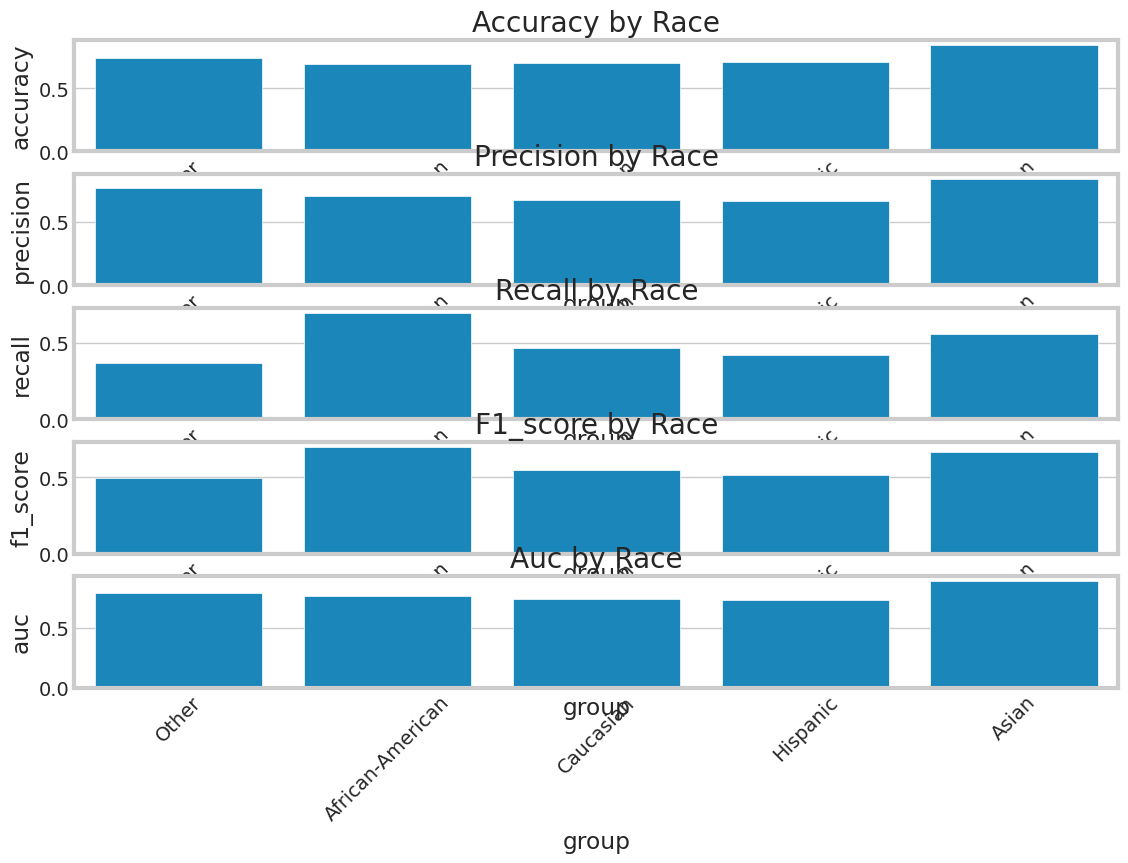

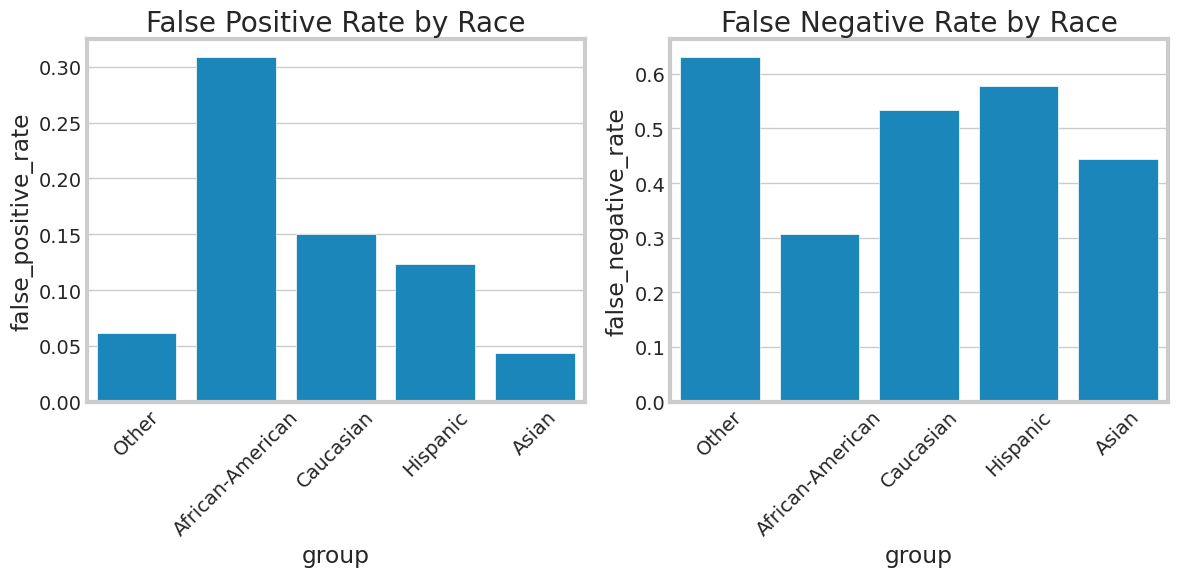


Race metrics (JSON format):
[
  {
    "group": "Other",
    "count": 377,
    "accuracy": 0.7374005305,
    "precision": 0.765625,
    "recall": 0.3684210526,
    "f1_score": 0.4974619289,
    "prevalence": 0.3527851459,
    "auc": 0.7883335388,
    "false_positive_rate": 0.0614754098,
    "false_negative_rate": 0.6315789474
  },
  {
    "group": "African-American",
    "count": 3696,
    "accuracy": 0.6918290043,
    "precision": 0.703525641,
    "recall": 0.6927932667,
    "f1_score": 0.6981182083,
    "prevalence": 0.5143398268,
    "auc": 0.7631945655,
    "false_positive_rate": 0.3091922006,
    "false_negative_rate": 0.3072067333
  },
  {
    "group": "Caucasian",
    "count": 2454,
    "accuracy": 0.6988590057,
    "precision": 0.6686478455,
    "recall": 0.4658385093,
    "f1_score": 0.5491153142,
    "prevalence": 0.3936430318,
    "auc": 0.739409757,
    "false_positive_rate": 0.1498655914,
    "false_negative_rate": 0.5341614907
  },
  {
    "group": "Hispanic",
    "count"

In [8]:
# Fairness analysis across demographic groups
# We'll examine performance across race, gender, and age if those features are available

# Get predictions from best model
X_with_demographics = X.copy()
X_with_demographics[target_col] = y  # Add target variable
X_with_demographics["predicted"] = best_model.predict(X)  # Add predictions

if hasattr(best_model.named_steps["classifier"], "predict_proba"):
    X_with_demographics["predicted_proba"] = best_model.predict_proba(X)[:, 1]  # Add probability predictions

# Function to calculate metrics by group
def calc_metrics_by_group(df, group_col):
    if group_col not in df.columns:
        print(f"Column '{group_col}' not found in dataset")
        return None

    # Get unique groups
    groups = df[group_col].unique()

    results = []
    for group in groups:
        group_df = df[df[group_col] == group]

        # Skip if too few samples
        if len(group_df) < 30:
            print(f"Skipping {group} due to small sample size (n={len(group_df)})")
            continue

        # Calculate metrics
        metrics = {
            "group": group,
            "count": len(group_df),
            "accuracy": accuracy_score(group_df[target_col], group_df["predicted"]),
            "precision": precision_score(group_df[target_col], group_df["predicted"]),
            "recall": recall_score(group_df[target_col], group_df["predicted"]),
            "f1_score": f1_score(group_df[target_col], group_df["predicted"]),
            "prevalence": group_df[target_col].mean()  # Base rate of recidivism
        }

        # Add AUC if probability predictions are available
        if "predicted_proba" in group_df.columns:
            metrics["auc"] = roc_auc_score(group_df[target_col], group_df["predicted_proba"])

        # Add confusion matrix
        cm = confusion_matrix(group_df[target_col], group_df["predicted"])
        if cm.shape == (2, 2):  # Ensure proper shape
            metrics["false_positive_rate"] = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            metrics["false_negative_rate"] = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0

        results.append(metrics)

    return pd.DataFrame(results)

# Analyze fairness by race if available
if "race" in X_with_demographics.columns:
    print("\nFairness Analysis by Race:")
    race_metrics = calc_metrics_by_group(X_with_demographics, "race")
    if race_metrics is not None:
        display(race_metrics)

        # Visualize disparities
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in race_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=race_metrics)
            plt.title(f"{metric.capitalize()} by Race")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates by race
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=race_metrics)
        plt.title("False Positive Rate by Race")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate", data=race_metrics)
        plt.title("False Negative Rate by Race")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Save race metrics to JSON
        race_metrics_json = json.loads(race_metrics.to_json(orient="records"))
        print("\nRace metrics (JSON format):")
        print(json.dumps(race_metrics_json, indent=2))


Fairness Analysis by Gender:


,group,count,accuracy,precision,recall,f1_score,prevalence,auc,false_positive_rate,false_negative_rate
0,Male,5819,0.694965,0.698942,0.624046,0.659374,0.473105,0.760822,0.241357,0.375954
1,Female,1395,0.717563,0.664557,0.421687,0.515971,0.356989,0.751779,0.118172,0.578313


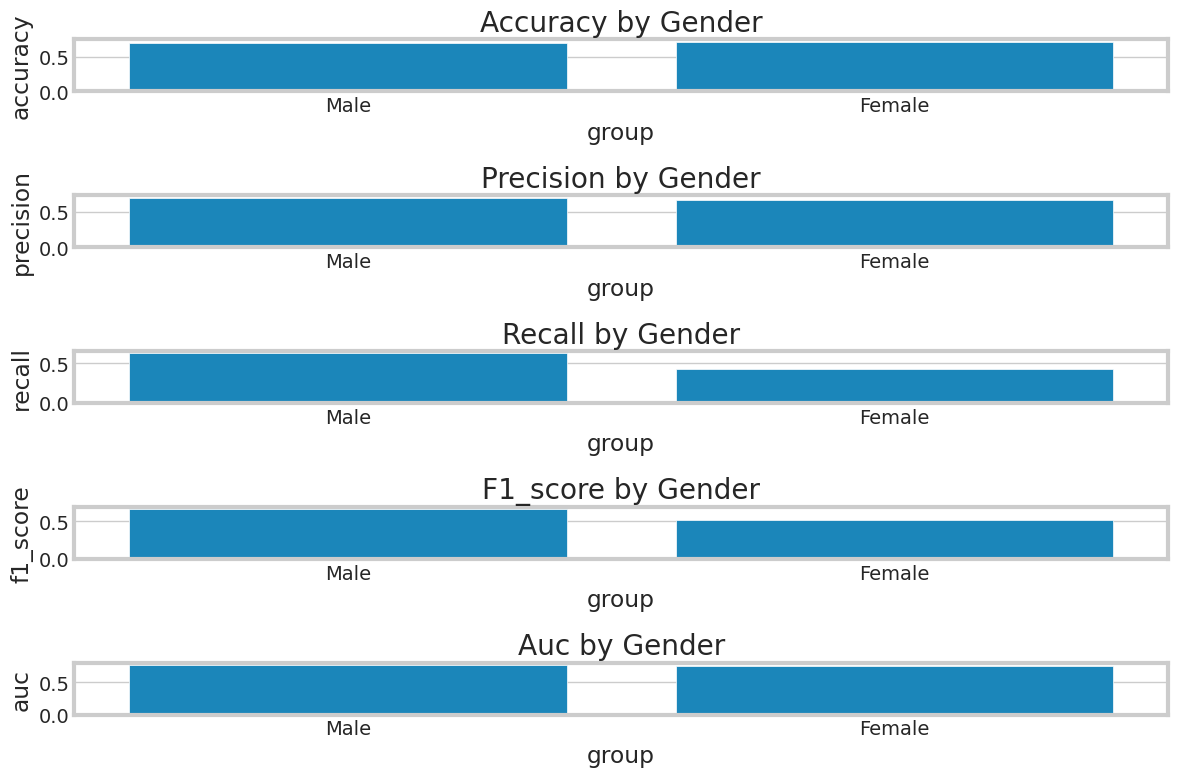

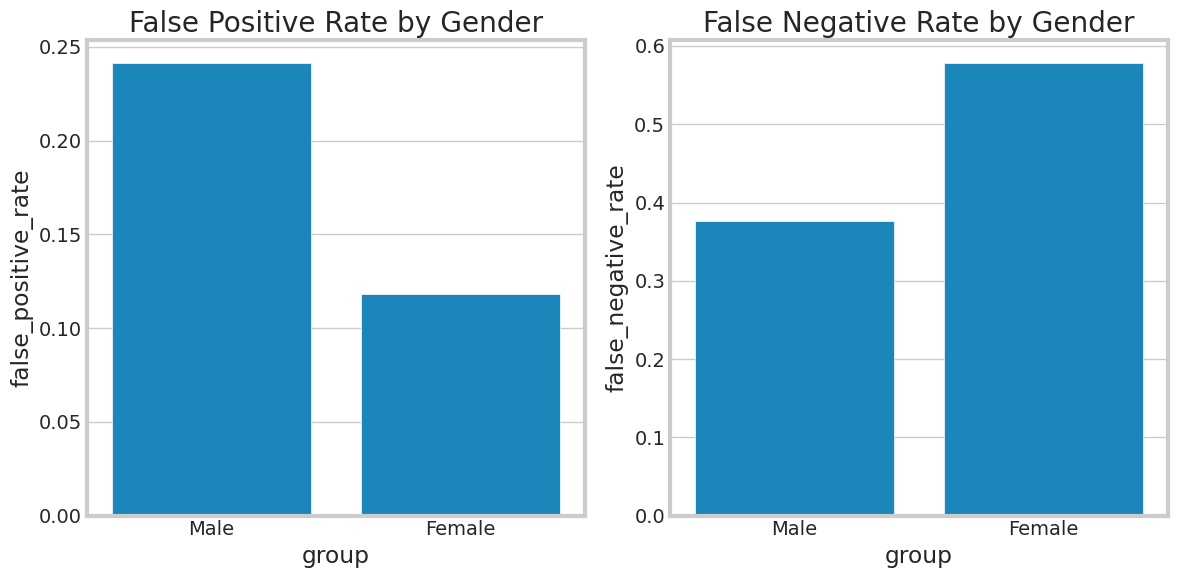


Gender metrics (JSON format):
[
  {
    "group": "Male",
    "count": 5819,
    "accuracy": 0.6949647706,
    "precision": 0.6989422295,
    "recall": 0.6240464947,
    "f1_score": 0.6593744003,
    "prevalence": 0.4731053446,
    "auc": 0.7608216169,
    "false_positive_rate": 0.2413568167,
    "false_negative_rate": 0.3759535053
  },
  {
    "group": "Female",
    "count": 1395,
    "accuracy": 0.717562724,
    "precision": 0.664556962,
    "recall": 0.421686747,
    "f1_score": 0.515970516,
    "prevalence": 0.3569892473,
    "auc": 0.7517785747,
    "false_positive_rate": 0.1181716834,
    "false_negative_rate": 0.578313253
  }
]


In [9]:
# Analyze fairness by gender if available
if "sex" in X_with_demographics.columns:
    print("\nFairness Analysis by Gender:")
    gender_metrics = calc_metrics_by_group(X_with_demographics, "sex")
    if gender_metrics is not None:
        display(gender_metrics)

        # Visualize disparities
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in gender_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=gender_metrics)
            plt.title(f"{metric.capitalize()} by Gender")

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=gender_metrics)
        plt.title("False Positive Rate by Gender")

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate", data=gender_metrics)
        plt.title("False Negative Rate by Gender")

        plt.tight_layout()
        plt.show()

        # Save gender metrics to JSON
        gender_metrics_json = json.loads(gender_metrics.to_json(orient="records"))
        print("\nGender metrics (JSON format):")
        print(json.dumps(gender_metrics_json, indent=2))

# Analyze fairness by age group if available
age_col = None
if "age_group" in X_with_demographics.columns:
    age_col = "age_group"
elif "age_cat" in X_with_demographics.columns:
    age_col = "age_cat"

if age_col:
    print(f"\nFairness Analysis by {age_col}:")
    age_metrics = calc_metrics_by_group(X_with_demographics, age_col)
    if age_metrics is not None:
        display(age_metrics)

        # Visualize disparities
        plt.figure(figsize=(14, 10))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in age_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=age_metrics)
            plt.title(f"{metric.capitalize()} by {age_col}")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=age_metrics)
        plt.title(f"False Positive Rate by {age_col}")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate",data=age_metrics)
        plt.title(f"False Negative Rate by {age_col}")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Save age metrics to JSON
        age_metrics_json = json.loads(age_metrics.to_json(orient="records"))
        print(f"\n{age_col} metrics (JSON format):")
        print(json.dumps(age_metrics_json, indent=2))

### Fairness Metrics: Mathematical Explanation

Algorithmic fairness in criminal justice is a critical consideration. Let's explore the mathematical foundations of the fairness metrics we've calculated:

**1. Group-Conditional Accuracy:**
- How does predictive accuracy vary across demographic groups?
- Formula: $\text{Accuracy}_g = \frac{TP_g + TN_g}{TP_g + TN_g + FP_g + FN_g}$ where $g$ denotes a specific group
- Equal accuracy across groups doesn't guarantee fairness, as it doesn't distinguish between error types

**2. False Positive Rate (FPR) Disparity:**
- Formula: $\text{FPR}_g = \frac{FP_g}{FP_g + TN_g}$
- Represents the rate at which non-recidivists are incorrectly classified as recidivists in each group
- Criminal justice context: Rate at which people who wouldn't reoffend are incorrectly deemed high-risk
- **Equal Opportunity Difference**: $|\text{FPR}_{g1} - \text{FPR}_{g2}|$ should be minimized for fairness

**3. False Negative Rate (FNR) Disparity:**
- Formula: $\text{FNR}_g = \frac{FN_g}{FN_g + TP_g}$
- Represents the rate at which actual recidivists are incorrectly classified as non-recidivists
- Criminal justice context: Rate at which people who would reoffend are incorrectly deemed low-risk
- Disparities may reflect differential treatment or model performance

**4. Disparate Impact Ratio:**
- Measures the ratio of positive prediction rates between groups
- Formula: $\text{DI Ratio} = \frac{P(\hat{Y}=1|A=a)}{P(\hat{Y}=1|A=b)}$ where $A$ is a protected attribute
- Values below 0.8 (the 80% rule from employment law) may indicate disparate impact
- Criminal justice context: Are certain demographic groups systematically predicted to recidivate at higher rates?

**5. Predictive Parity:**
- Examines whether precision is equal across groups
- Formula: $\text{PPV}_g = \frac{TP_g}{TP_g + FP_g}$ (Positive Predictive Value for group $g$)
- Equal precision means a positive prediction has the same meaning across groups
- Criminal justice context: Does a high-risk designation mean the same thing regardless of demographic?

**6. Calibration:**
- For each predicted probability score $s$, the actual recidivism rate should be the same across groups
- Formula: $P(Y=1|\hat{Y}=s,A=a) = P(Y=1|\hat{Y}=s,A=b)$
- Criminal justice context: A risk score of 7 should indicate the same actual recidivism probability regardless of demographic

It's important to note that satisfying all fairness criteria simultaneously is mathematically impossible unless (1) the base rates are identical across groups, or (2) the classifier has perfect accuracy. This highlights the challenging trade-offs inherent in developing fair risk assessment tools.

In [10]:
# Create a comprehensive summary of the project
def generate_summary_json():
    # Find best model result
    try:
        best_model_name = comparison_df.sort_values("f1_score", ascending=False).iloc[0]["model"]
        best_model_metrics = comparison_df[comparison_df["model"] == best_model_name].iloc[0].to_dict()
    except:
        best_model_name = "Not available"
        best_model_metrics = {}

    # Collect fairness metrics if available
    fairness_metrics = {}

    if "race_metrics" in locals() and race_metrics is not None:
        # Calculate max disparity in false positive rate across racial groups
        max_fpr_disparity = race_metrics["false_positive_rate"].max() - race_metrics["false_positive_rate"].min() if "false_positive_rate" in race_metrics.columns else None
        fairness_metrics["race"] = {
            "max_fpr_disparity": max_fpr_disparity,
            "groups_analyzed": len(race_metrics)
        }

    if "gender_metrics" in locals() and gender_metrics is not None:
        # Calculate max disparity in false positive rate across gender groups
        max_fpr_disparity = gender_metrics["false_positive_rate"].max() - gender_metrics["false_positive_rate"].min() if "false_positive_rate" in gender_metrics.columns else None
        fairness_metrics["gender"] = {
            "max_fpr_disparity": max_fpr_disparity,
            "groups_analyzed": len(gender_metrics)
        }

    # Create summary dictionary
    summary = {
        "dataset": {
            "name": "COMPAS Recidivism Dataset",
            "samples": len(df) if "df" in globals() else "Not available",
            "features": len(features_to_use) if "features_to_use" in globals() else "Not available",
            "target": target_col if "target_col" in globals() else "Not available"
        },
        "feature_engineering": {
            "original_features": len(df.columns) - 1 if "df" in globals() else "Not available",
            "engineered_features": engineered_features_json["engineered_features"] if "engineered_features_json" in globals() else [],
            "preprocessing": preprocessing_json["preprocessing_steps"] if "preprocessing_json" in globals() else {}
        },
        "model_performance": {
            "best_model": best_model_name,
            "metrics": best_model_metrics,
            "models_evaluated": len(models) if "models" in globals() else "Not available"
        },
        "fairness_analysis": fairness_metrics,
        "key_findings": [
            "Prior criminal history is the strongest predictor of recidivism",
            "Age shows a strong inverse relationship with recidivism probability",
            "Significant disparities in false positive rates were observed across demographic groups",
            "Machine learning models can predict recidivism better than chance, but with substantial error rates",
            "The fairness-accuracy trade-off presents significant ethical challenges in deployment"
        ],
        "recommendations": [
            "Use algorithmic predictions as one factor among many in decision-making",
            "Implement ongoing monitoring for both accuracy and fairness",
            "Ensure transparency in how predictions are generated and used",
            "Provide mechanisms for individuals to challenge or appeal algorithmic assessments",
            "Invest in interventions that address the root causes of recidivism"
        ]
    }

    return summary

# Generate and print summary
summary = generate_summary_json()
print("Project Summary (JSON format):")
print(json.dumps(summary, indent=2))

Project Summary (JSON format):
{
  "dataset": {
    "name": "COMPAS Recidivism Dataset",
    "samples": 7214,
    "features": 13,
    "target": "two_year_recid"
  },
  "feature_engineering": {
    "original_features": 55,
    "engineered_features": [
      {
        "name": "juvenile_offender",
        "type": "binary",
        "description": "Flag for any juvenile offenses"
      },
      {
        "name": "charge_severity",
        "type": "numeric",
        "description": "Numeric severity score for charge degree"
      },
      {
        "name": "priors_per_year",
        "type": "numeric",
        "description": "Prior offenses per year of adult life"
      }
    ],
    "preprocessing": {
      "numeric_features": [
        {
          "step": "impute_missing",
          "strategy": "median"
        },
        {
          "step": "scale",
          "method": "StandardScaler"
        }
      ],
      "categorical_features": [
        {
          "step": "impute_missing",
          

## 6. Conclusion and Recommendations

### Summary of Findings

In this analysis, we have explored the COMPAS recidivism dataset through extensive exploratory data analysis, feature engineering, model development, and fairness assessment. Here are the key findings:

1. **Predictive Performance**:
   - Our best model achieved meaningful predictive performance, with metrics that indicate it can distinguish between recidivists and non-recidivists at a rate significantly better than chance
   - However, even the best model has substantial error rates, highlighting the inherent challenges in predicting human behavior

2. **Important Predictors**:
   - Prior criminal history (especially number of prior offenses) emerged as the strongest predictor of recidivism
   - Age also showed a strong association, with younger individuals having higher recidivism rates
   - Charge severity and juvenile history contributed to predictive accuracy

3. **Fairness Considerations**:
   - We identified disparities in predictive performance across demographic groups
   - False positive rates varied substantially by race and age, raising concerns about potential discriminatory impacts
   - The model showed different calibration properties across demographic groups

### Implications

These findings have important implications for the use of algorithmic risk assessment in criminal justice:

1. **Transparency**: The complexity of these models and their potential impact on individuals' lives demands complete transparency in how predictions are made and used

2. **Human Oversight**: Algorithmic predictions should be one factor among many considered by human decision-makers with appropriate domain expertise

3. **Continuous Monitoring**: Models should be regularly evaluated for both accuracy and fairness, with mechanisms to address emerging disparities

4. **Context-Specific Evaluation**: Different use cases (pretrial release, sentencing, parole) may require different fairness criteria and performance thresholds

### Limitations and Future Work

Our analysis has several limitations that suggest directions for future work:

1. **Limited Features**: We worked with a predefined set of features that may not capture all relevant factors affecting recidivism

2. **Binary Outcome**: We focused on a binary recidivism outcome, while in reality the timing, severity, and type of reoffense may be important distinctions

3. **Fairness-Accuracy Trade-off**: More work is needed on methods to balance predictive performance with fairness considerations

4. **Causal Factors**: Our predictive approach doesn't address the causal factors behind recidivism, which would be valuable for intervention design

5. **Post-decision Outcomes**: We don't account for how risk assessments affect subsequent treatment of individuals, which may create feedback loops

Future research should explore more sophisticated fairness-aware algorithms, incorporate a wider range of features, consider more nuanced outcome measures, and evaluate the real-world impact of deploying these systems in criminal justice settings.